# Finding optimal values for A1 and A2 coefficient

Given an "ideal" initial snow density, we try to determine what is the best pair of (A1, A2) coefficients, using 3 different metrics (see Notebook 19).

**WARNING: THE OPTIMIZATION MAY DEPEND ON THE OFFSET VALUE > PERHAPS A GRAPH MAY BE HELPFUL.**

## Imports and functions

In [38]:
from joblib import Parallel, delayed
import math
from scipy.stats import sem
from matplotlib.patches import Rectangle

In [2]:
%run little_awk_functions.py

In [3]:
def rmse_measure(simul_total_height_array, lidar_height_array):
    '''
    Functionthat computes the root mean square error between two arrays
    Args:
        simul_total_height_array: array containing the total height of the simulated snowpack at each timestamp
        lidar_height_array: array containing the height of the snowpack measured by the lidar at each timestamp
    Returns:
        rmse: root mean square error between the two arrays
    '''
    mse = np.square(np.subtract(simul_total_height_array, lidar_height_array)).mean()
    rmse = math.sqrt(mse)
    
    return(rmse)

In [4]:
def stderr_measure(simul_total_height_array, lidar_height_array):
    '''
    Function that computes the standard error of the difference of two arrays (measures to what extent the two series are "parallel", the smaller the better)
    Args:
        simul_total_height_array: array containing the total height of the simulated snowpack at each timestamp
        lidar_height_array: array containing the height of the snowpack measured by the lidar at each timestamp
    Returns:
        stderr: standard error of the difference of the two arrays
    '''
    difference = simul_total_height_array - lidar_height_array
    stderr = sem(difference)
    
    return(stderr)

In [5]:
def p_correl_measure(simul_total_height_array, lidar_height_array):
    '''
    Function that computes the Pearson correlation between two arrays
    Args:
        simul_total_height_array: array containing the total height of the simulated snowpack at each timestamp
        lidar_height_array: array containing the height of the snowpack measured by the lidar at each timestamp
    Returns:
        p_correl: Pearson correlation between the two arrays
    '''
    dataframe = {
        "Array_1": simul_total_height_array,
        "Array_2": lidar_height_array
    }

    data = pd.DataFrame(dataframe)
    p_correl = data.corr().iloc[0, 1]
    
    return(p_correl)

In [6]:
def all_measures(a1, a2, simul_total_height_array, lidar_height_array):
    '''
    Function that computes the rmse, standard error of the difference and Pearson correlation between two arrays
    Args:
        a1: a1 value used to obtain simul_total_height_array
        a2: a2 value used to obtain simul_total_height_array
        simul_total_height_array: array containing the total height of the simulated snowpack at each timestamp
        lidar_height_array: array containing the height of the snowpack measured by the lidar at each timestamp
    Returns:
        a1, a2: unchanged values, used for identification of the results
        all_measrs: tuple containing the computed values in the order (rmse, stde, p_corr)
    '''
    all_measrs = rmse_measure(simul_total_height_array, lidar_height_array), stderr_measure(simul_total_height_array, lidar_height_array), p_correl_measure(simul_total_height_array, lidar_height_array)
    
    return(a1, a2, all_measrs)

In [7]:
def single_simulation(data_set_used, x_sel, y_sel, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2,
                      met_temp, met_time, simul_new_snow_ro, simul_fit_top_of_snowfall_to_curve):
    '''
    Function that uses the simulate_snowpack_evolution() function to simulate the snowpack's evolution for a given (a1, a2) pair
    Args:
        data_duration_in_s: total duration of the lidar data, in seconds
        ds_time_indices: indices of the simulation that correspond to the lidar data (and should thus be the only to be kept)
        for all other arguments, please refer to the simulate_snowpack_evolution() docstring
    Returns:
        an np-array containing:
        a1, a2: unchanged values, used for identification of the results
        total_snow_depth: array containing the depth of the snowpack at each timestamp
    '''
    nb_iterations = int(data_duration_in_s/dt + 1)

    # Update variables at each timepoint

    snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
     
    # Define total_snow_depth
    
    # simulation_times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    total_snow_depth = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution)) if i in ds_time_indices])
    
    return(np.array([a1, a2, total_snow_depth], dtype=object))

In [8]:
def parallel_simulation(data_set_used, x_sel, y_sel, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1_range, a2_range,
                      met_temp, met_time, simul_new_snow_ro, simul_fit_top_of_snowfall_to_curve):
    '''
    Function that runs single_simulation() in parallel for a range of values of a1 and a2
    Args:
        data_duration_in_s: total duration of the lidar data, in seconds
        ds_time_indices: indices of the simulation that correspond to the lidar data (and should thus be the only to be kept)
        for all other arguments, please refer to the simulate_snowpack_evolution() docstring
    Returns:
        p_s: array containing the [a1, a2, total_snow_depth] results computed for each pair of (a1, a2) arguments
    '''
    a1_a2_range = [(a1, a2) for a1 in a1_range for a2 in a2_range]
    
    p_s = Parallel(n_jobs=-2)(delayed(single_simulation)(data_set_used, x_sel, y_sel, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow,
                      melt_flag, a1, a2, met_temp, met_time, simul_new_snow_ro, simul_fit_top_of_snowfall_to_curve) for (a1, a2) in a1_a2_range)
    
    return(np.array(p_s, dtype=object))

In [9]:
# convert lidar timepoints to match simulation times > see first metrics functions

def parallel_measures(parallel_simulations_array, lidar_height_array):
    '''
    Function that runs all_measures() in parallel for a range of values of a1 and a2
    Args:
        parallel_simulations_array: array containing the [a1, a2, total_snow_depth] results of simulations computed for each pair of (a1, a2) arguments
        lidar_height_array: array containing the depth of the snowpack as measured by the lidar, corresponding to each simulation timestamp
    Returns:
        p_m: array containing the [a1, a2, (rmse, stde, p_corr)] measure results computed for each pair of (a1, a2) arguments
    '''
    p_m = Parallel(n_jobs=-2)(delayed(all_measures)(parallel_simulations_array[i][0], parallel_simulations_array[i][1], parallel_simulations_array[i][2], lidar_height_array)  # a1, a2, simul_total_height_array
                       for i in range(len(parallel_simulations_array)))
    
    return(p_m)

In [10]:
p_s_a = np.array([[0.1, 0.5, [1, 3, 4, 0]], [0.2, 0.6, [1, 4, 4, 0]], [0.3, 0.7, [3, 1, 0, 4]]], dtype=object)
l_h_a = np.array([3, 1, 0, 4])

parallel_measures(p_s_a, l_h_a)

[(0.1, 0.5, (3.1622776601683795, 1.8257418583505538, -1.0)),
 (0.2, 0.6, (3.3541019662496847, 1.9311050377094112, -0.9741763740941048)),
 (0.3, 0.7, (0.0, 0.0, 1.0))]

## Define default parameters

In [11]:
paramdic = {}

In [12]:
# Dataset

name_of_data_set = 'snow_pit_1_filled.nc'      # TODO partial?
offset = 0.35414986           # TODO deal with this
# data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0]) can be chosen as offset (run a first computation first with offset set to 0)

save_figures = False
save_text_results = False

directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/current_development/A1_A2_optimum/'

paramdic['data_set_used'] = name_of_data_set
paramdic['offset'] = offset

In [13]:
# Events detection parameters

x_sel = 10
y_sel = 10
time_window_std = 25
std_threshold = 0.015    # TODO choose the correct threshold here

paramdic['x_sel'] = x_sel
paramdic['y_sel'] = y_sel
paramdic['time_window_std'] = time_window_std
paramdic['std_threshold'] = std_threshold

In [14]:
# Compaction/temperature model parameters

tsfc = -5
cp_snow = 2106
dt = 100
a1 = 0.0013
a2 = 0.021

use_true_temp = False   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 150         # TODO choose the correct value here

# TODO add ice layer detection option > not yet

paramdic['tsfc'] = tsfc
paramdic['cp_snow'] = cp_snow
paramdic['dt'] = dt
paramdic['a1'] = a1
paramdic['a2'] = a2
paramdic['use_true_temp'] = use_true_temp
paramdic['simul_new_snow_ro'] = simul_new_snow_ro

# Will not be varied for now

max_nb_of_layers = 25
simul_fit_top_of_snowfall_to_curve = False
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

paramdic['stable_parameters'] = 'max nb layers 25; do not fit top of snowfall to curve; tf 0; ro water 1000; ro ice 910; initial nb layers 0'

In [15]:
a1_range = np.linspace(0.001, 0.005, num=15, endpoint=True)
a2_range = np.linspace(0.02, 0.04, num=10, endpoint=True)

paramdic['a1_range'] = a1_range
paramdic['a2_range'] = a2_range

In [16]:
# Couples of values to plot the lidar graph of

couples_to_plot = [(a1_range[1], a2_range[1]), (a1_range[-2], a2_range[-2]), (a1_range[-2], a2_range[1]), (a1_range[1], a2_range[-2]), (a1_range[7], a2_range[8])]
print(couples_to_plot)

[(0.0012857142857142859, 0.022222222222222223), (0.004714285714285714, 0.03777777777777778), (0.004714285714285714, 0.022222222222222223), (0.0012857142857142859, 0.03777777777777778), (0.003, 0.03777777777777778)]


In [17]:
# Save default parameters in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(str(paramdic) + '\n \n')

## Clean dataset and derive other parameters

In [18]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(name_of_data_set)

if name_of_data_set == 'data_2021-2022.nc':
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
if name_of_data_set == 'data_2021-2022.nc':
    median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - offset


---> Median filtering in space with a window [7, 11]


In [19]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime('2021-12-06T00:00')      # TODO make sure this is the right date > functionalize? can just use data_starting_date_in_s?

In [20]:
# Define structures to store snow parameters

ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
age_layers = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))

In [21]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()
else:
    met_time, met_temp = [0], [tsfc]

In [22]:
results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

In [23]:
lidar_height_array = []
keep_simul_times_indices = []    # indices of the timestamps to keep in the simulation data, that are comparable to the lidar data
                                # given that dt << lidar scans time period, there are no repetitions in keep_simul_times_indices
ignore = np.isnan(data_set_used.snow_surface.isel(x=x_sel, y=y_sel))     # do not take into account the nan values in the dataset

for index in range(len(data_set_used.time.values)):
        lidar_time_in_s = float(data_set_used.time.values[index]) / 1000000000 - float(data_set_used.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt and not ignore[index]:
            lidar_height_array.append(data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=index))

            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            keep_simul_times_indices.append(index_of_closest_time_in_simul)

lidar_height_array = np.array(lidar_height_array)

## Loop on parameters A1 and A2

In [24]:
simul = parallel_simulation(data_set_used, x_sel, y_sel, data_duration_in_s, keep_simul_times_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1_range, a2_range,
                      met_temp, met_time, simul_new_snow_ro, simul_fit_top_of_snowfall_to_curve)


In [25]:
measrs = parallel_measures(simul, lidar_height_array)


In [26]:
# measrs

In [27]:
#with open(directory_to_save_figs_in + 'a1_a2_results.txt', 'a') as results_file:
 #   results_file.write(str(measrs) + '\n \n')


In [28]:
# a1
simul[0][0]
# a2
simul[0][1]

0.02

In [29]:
test = '''fig = plt.figure()
ax = fig.add_subplot(projection='3d')

a1 = [0.2, 0.3, 0.2, 0.3]
a2 = [0.1, 0.1, 0.15, 0.15]
rmse = [0.1, 0.2, 0.5, 0.15]

ax.scatter(a1, a2, rmse, marker='v'for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show())

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()'''

In [30]:
for i in range(len(measrs)):
    if measrs[i][2][2] == max(measrs[i][2][2] for i in range(len(measrs))):
        print('Pearson correlation max: ', measrs[i])
    if measrs[i][2][1] == min(measrs[i][2][1] for i in range(len(measrs))):
        print('Std error min: ', measrs[i])
    if measrs[i][2][0] == min(measrs[i][2][0] for i in range(len(measrs))):
        print('RMSE min: ', measrs[i])


Std error min:  (0.004714285714285714, 0.026666666666666665, (0.054112555136085844, 0.0006156675509275042, 0.9717528721175012))
RMSE min:  (0.004714285714285714, 0.026666666666666665, (0.054112555136085844, 0.0006156675509275042, 0.9717528721175012))
Pearson correlation max:  (0.005, 0.026666666666666665, (0.0542055717112294, 0.0006162350712097993, 0.9717971532493045))


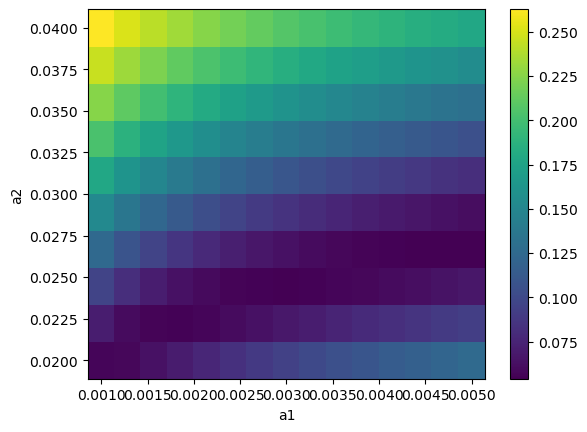

In [31]:
# RMSE measure > min is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][0] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

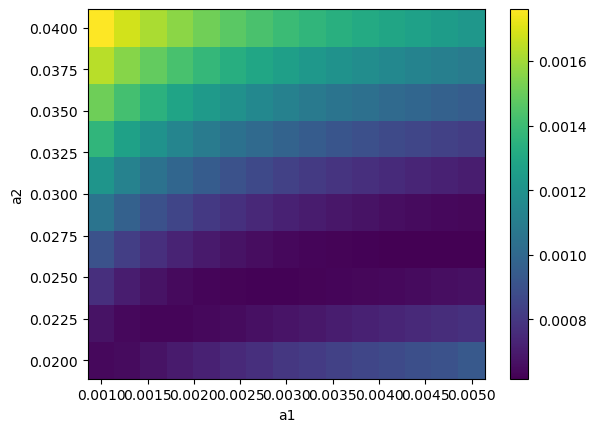

In [32]:
# Std error measure > min is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][1] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

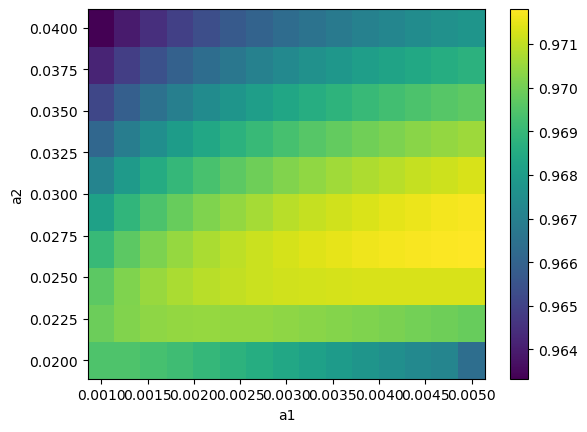

In [33]:
# Pearson correlation measure > max is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][2] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

## Plot results

In [146]:
a1_step = a1_range[1]-a1_range[0]
a2_step = a2_range[1]-a2_range[0]

optimum_coords = [5, 5]

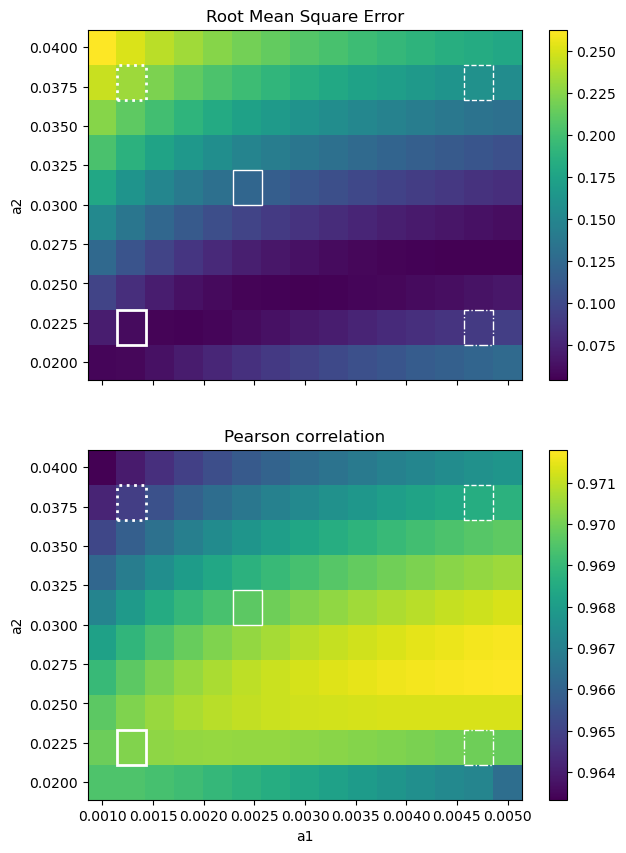

In [147]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10))

for ax in axs.flat:
    ax.set(xlabel='a1', ylabel='a2')
    # ax.set_xticks(a1_range * 1000, ['%d' % val for val in a1_range])
    # ax.set_xticks(a1_range)# * 100) 
    # ax.set_xticklabels(['%d' % val for val in a1_range])
    ax.label_outer()

x = a1_range
y = a2_range
z_rmse = np.array([measrs[i][2][0] for i in range(len(measrs))])
z_corr = np.array([measrs[i][2][2] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z_rmse = z_rmse.reshape(len(x), len(y)).T
Z_corr = z_corr.reshape(len(x), len(y)).T

fig0 = axs[0].pcolor(X, Y, Z_rmse)
axs[0].set_title('Root Mean Square Error')
fig.colorbar(fig0, ax=axs[0])

axs[0].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=2, ls='-'))
axs[0].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='--'))
axs[0].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-.'))
axs[0].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=2, ls=':'))
axs[0].add_patch(Rectangle((a1_range[optimum_coords[0]] - a1_step/2, a2_range[optimum_coords[1]] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))   # TODO last one should be modular

fig1 = axs[1].pcolor(X, Y, Z_corr)
axs[1].set_title('Pearson correlation')
fig.colorbar(fig1, ax=axs[1])

axs[1].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=2, ls='-'))
axs[1].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='--'))
axs[1].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-.'))
axs[1].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=2, ls=':'))
axs[1].add_patch(Rectangle((a1_range[optimum_coords[0]] - a1_step/2, a2_range[optimum_coords[1]] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))   # TODO last one should be modular


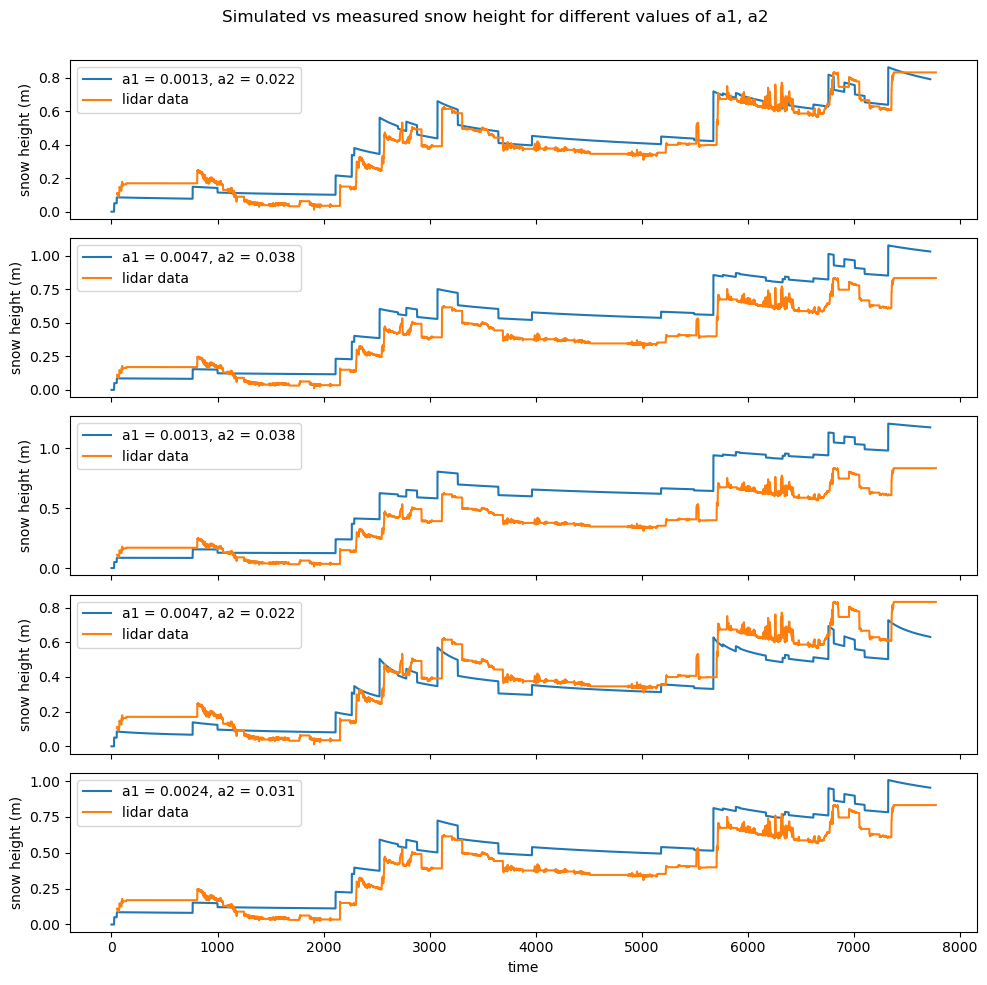

In [148]:
optimum_index = optimum_coords[0]*len(a2_range) + optimum_coords[1]

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='snow height (m)')
    ax.label_outer()

axs[0].plot(simul[len(a2_range)+1][2], label='a1 = '+str(round(simul[len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[len(a2_range)+1][1], 3)))
axs[0].plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
axs[0].legend()

axs[1].plot(simul[-2*len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][1], 3)))
axs[1].plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
axs[1].legend()

axs[2].plot(simul[len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][1], 3)))
axs[2].plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
axs[2].legend()

axs[3].plot(simul[-2*len(a2_range)+1][2], label='a1 = '+str(round(simul[-2*len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+1][1], 3)))
axs[3].plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
axs[3].legend()

axs[4].plot(simul[optimum_index][2], label='a1 = '+str(round(simul[optimum_index][0], 4))+', a2 = '+str(round(simul[optimum_index][1], 3)))
axs[4].plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
axs[4].legend()

fig.suptitle('Simulated vs measured snow height for different values of a1, a2')
fig.tight_layout()
fig.subplots_adjust(top=0.93)

Text(0.5, 1.0, 'Simulated vs measured snow height for different values of a1, a2')

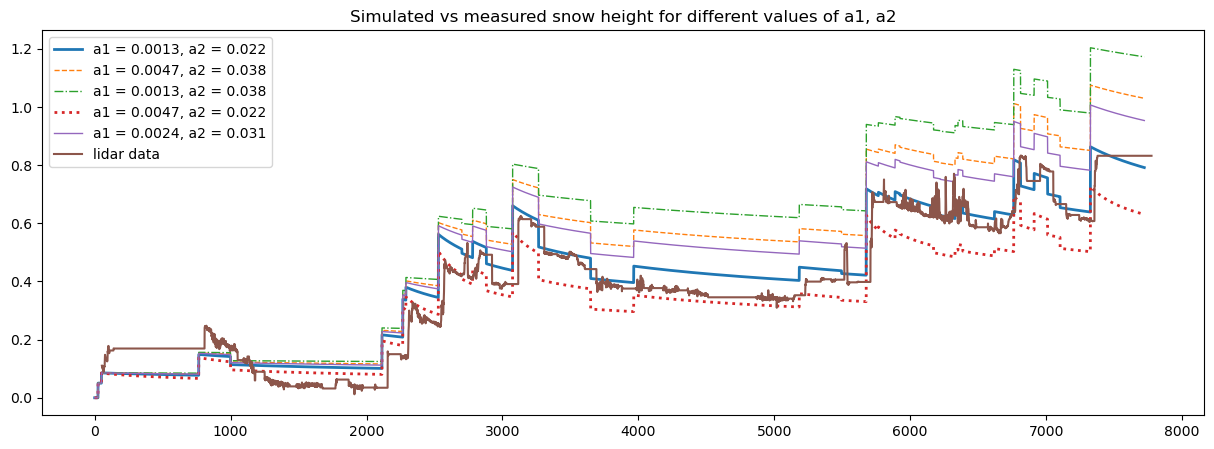

In [159]:
# Other option for presentation of results (change fig sizes, make first one horizontal for eg.)

optimum_index = optimum_coords[0]*len(a2_range) + optimum_coords[1]

fig = plt.figure(figsize=(15, 5))

fig.xlabel='time'
fig.ylabel='snow height (m)'

plt.plot(simul[len(a2_range)+1][2], linestyle='-', linewidth=2, label='a1 = '+str(round(simul[len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[len(a2_range)+1][1], 3)))
plt.plot(simul[-2*len(a2_range)+(len(a2_range)-2)][2], linestyle='--', linewidth=1, label='a1 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][1], 3)))
plt.plot(simul[len(a2_range)+(len(a2_range)-2)][2], linestyle='-.', linewidth=1, label='a1 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][1], 3)))
plt.plot(simul[-2*len(a2_range)+1][2], linestyle=':', linewidth=2, label='a1 = '+str(round(simul[-2*len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+1][1], 3)))

plt.plot(simul[optimum_index][2], linestyle='-', linewidth=1, label='a1 = '+str(round(simul[optimum_index][0], 4))+', a2 = '+str(round(simul[optimum_index][1], 3)))

plt.plot(data_set_used.snow_surface.isel(x=x_sel, y=y_sel), label='lidar data')
plt.legend()

plt.title('Simulated vs measured snow height for different values of a1, a2')

# TODO adjust colors and alphas

In [149]:
# TODO: find a way of identifying each couple-point to the corresponding graph